# Цель работы

**Цель** - провести А/В тестирование нового алгоритма рекомендаций с использованием новой метрики (линеаризованные лайки).

**Идея** - посмотреть насколько отличаются результаты A/B тестирования c использованием индивидуального CTR как ключевой мtтрики от линеаризованных лайков.

**Задачи**:
1. Посчитать по формулам ноую метрику.
2. Провести A/A тесты, чтобы проверить группы на равенство до эксперенмта (+ что они статистически эквивалентны)
3. Проводим A/B тесты с использованием индивидуального CTR и с использованием линеаризованных лайков (новой метрики). Сравниваем результаты в двух группах эксперементов:
    * Первая группа - группа 0 (контрольная), группа 3 (эксперементальная). 
    * Вторая группа - группа 1 (контрольная), группа 2 (эксперементальная).
4. Делаем выводы.

**Метрика**

1. Считаем общий CTR в контрольной группе:     
    𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
2. Посчитаем в обеих группах поюзерную метрику:     
    𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 

# Анализ

## Подготовка к анализу

#### Основной

In [3]:
# Загружаем библиотеки

import pandahouse
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Соединияемся с сервером из ClickHouse

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230320'
}

In [5]:
# Выбираем данные для анализа результатов эксперимента

q_03 = """
        SELECT 
                exp_group,
                user_id,
                sum(action = 'like') as likes,
                sum(action = 'view') as views,
                likes / views as CTR
        FROM {db}.feed_actions 
        WHERE toDate(time) between '2023-03-02' and '2023-03-08'
                and exp_group in (0, 3)
        GROUP BY exp_group, user_id

       """

q_12 = """
        SELECT 
                exp_group,
                user_id,
                sum(action = 'like') as likes,
                sum(action = 'view') as views,
                likes / views as CTR
        FROM {db}.feed_actions 
        WHERE toDate(time) between '2023-03-02' and '2023-03-08'
                and exp_group in (1, 2)
        GROUP BY exp_group, user_id

       """

# А также для AA теста

q_03_aa = """
            SELECT 
                    exp_group,
                    user_id,
                    sum(action = 'like') as likes,
                    sum(action = 'view') as views,
                    likes / views as CTR
            FROM {db}.feed_actions 
            WHERE toDate(time) between '2023-02-22' and '2023-02-28'
                    and exp_group in (0, 3)
            GROUP BY exp_group, user_id

          """

q_12_aa = """
            SELECT 
                    exp_group,
                    user_id,
                    sum(action = 'like') as likes,
                    sum(action = 'view') as views,
                    likes / views as CTR
            FROM {db}.feed_actions 
            WHERE toDate(time) between '2023-02-22' and '2023-02-28'
                    and exp_group in (1, 2)
            GROUP BY exp_group, user_id

          """

In [6]:
# Создаем датафреймы

df_03 = pandahouse.read_clickhouse(q_03, connection=connection)
df_12 = pandahouse.read_clickhouse(q_12, connection=connection)

df_03_aa = pandahouse.read_clickhouse(q_03_aa, connection=connection)
df_12_aa = pandahouse.read_clickhouse(q_12_aa, connection=connection)

In [7]:
# Настраиваем размер графиков
sns.set(rc={'figure.figsize': (11.7, 8.27)})

## Cчитаем метрику

In [8]:
# Считаем общий CTR в контрольных группах (0 и 1) для эксперемента

CTR_control_0 = sum(df_03[df_03.exp_group == 0].likes) / sum(df_03[df_03.exp_group == 0].views)
CTR_control_1 = sum(df_12[df_12.exp_group == 1].likes) / sum(df_12[df_12.exp_group == 1].views)

# И для AA теста

CTR_control_0_aa = sum(df_03_aa[df_03_aa.exp_group == 0].likes) / sum(df_03_aa[df_03_aa.exp_group == 0].views)
CTR_control_1_aa = sum(df_12_aa[df_12_aa.exp_group == 1].likes) / sum(df_12_aa[df_12_aa.exp_group == 1].views)

In [9]:
# Cчитаем поюзеную метрику в каждой группе для эксперемента

df_03['linearized_likes'] = df_03.likes - CTR_control_0 * df_03.views
df_12['linearized_likes'] = df_12.likes - CTR_control_1 * df_12.views

# И для AA теста

df_03_aa['linearized_likes'] = df_03_aa.likes - CTR_control_0_aa * df_03_aa.views
df_12_aa['linearized_likes'] = df_12_aa.likes - CTR_control_1_aa * df_12_aa.views

## Первичный анализ данных

#### AA тест

In [10]:
# Смотрим, чтобы количество наблюдений в группах не сильно отличалось

print(df_03_aa.groupby('exp_group').count())
print(df_12_aa.groupby('exp_group').count())

           user_id  likes  views   CTR  linearized_likes
exp_group                                               
0             8373   8373   8373  8373              8373
3             8451   8451   8451  8451              8451
           user_id  likes  views   CTR  linearized_likes
exp_group                                               
1             8423   8423   8423  8423              8423
2             8342   8342   8342  8342              8342


Text(0, 0.5, 'Кол-во')

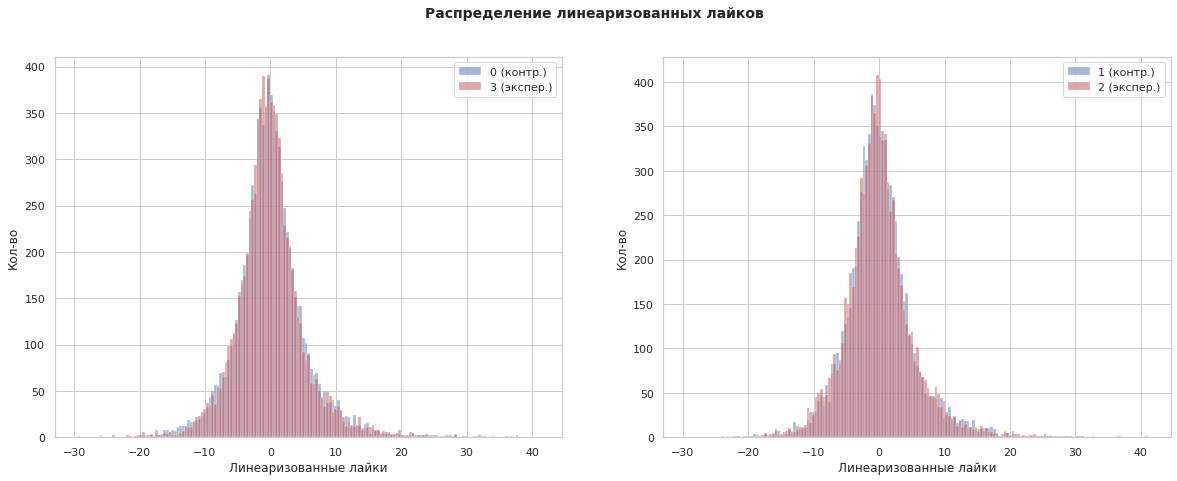

In [33]:
## Смотрим на распределение ключевой метрики (linearized_likes) в каждой группе ЗА неделю до эксперемента

# Создаем настройки для объединения графиков
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(20, 7), sharex=True)
fig.suptitle(f'Распределение линеаризованных лайков', fontweight='bold',fontsize=14)
# Задаем позиции
ax_1 = ax[0]
ax_2 = ax[1]

# Группы 0 и 3
sns.set_style("whitegrid")
groups = sns.histplot(data=df_03_aa,
                     x='linearized_likes',
                     hue='exp_group',
                     palette=['r', 'b'],
                     alpha=0.5,
                     kde=False,
                     legend=True,
                     ax=ax_1)
# Добавляем подписи 
ax_1.legend(['0 (контр.)','3 (экспер.)'])
ax_1.set_xlabel('Линеаризованные лайки')
ax_1.set_ylabel('Кол-во')

# Группы 1 и 2
sns.set_style("whitegrid")
sns.histplot(data=df_12_aa,
                     x='linearized_likes',
                     hue='exp_group',
                     palette=['r', 'b'],
                     alpha=0.5,
                     kde=False,
                     legend=True,
                     ax=ax_2)

# Добавляем подписи
ax_2.legend(['1 (контр.)','2 (экспер.)'])
ax_2.set_xlabel('Линеаризованные лайки')
ax_2.set_ylabel('Кол-во')

In [85]:
# Cверяем наши наблюдения с результатами ttest (распределение +- нормальное)

ttest_03_aa = stats.ttest_ind(df_03_aa[df_03_aa.exp_group == 0].linearized_likes, df_03_aa[df_03_aa.exp_group == 3].linearized_likes)
ttest_12_aa = stats.ttest_ind(df_12_aa[df_12_aa.exp_group == 1].linearized_likes, df_12_aa[df_12_aa.exp_group == 2].linearized_likes)

print('Результаты AA теста')
print(f'  p-value для групп 0 и 3: {ttest_03_aa[1]}', f'  p-value для групп 1 и 2: {ttest_12_aa[1]}', sep="\n")True

Результаты AA теста
  p-value для групп 0 и 3: 0.5783275494199667
  p-value для групп 1 и 2: 0.04428982299635346


**Вывод**: 
1. Для групп 0 и 3 все хорошо, группы статистически эквивалентны (наколько это возможно). Можно переходить к тестам.
2. Однако результаты групп 1 и 2 почти на грани (p-value < 0.05)

## Анализ - А/В 

Text(0, 0.5, 'Кол-во')

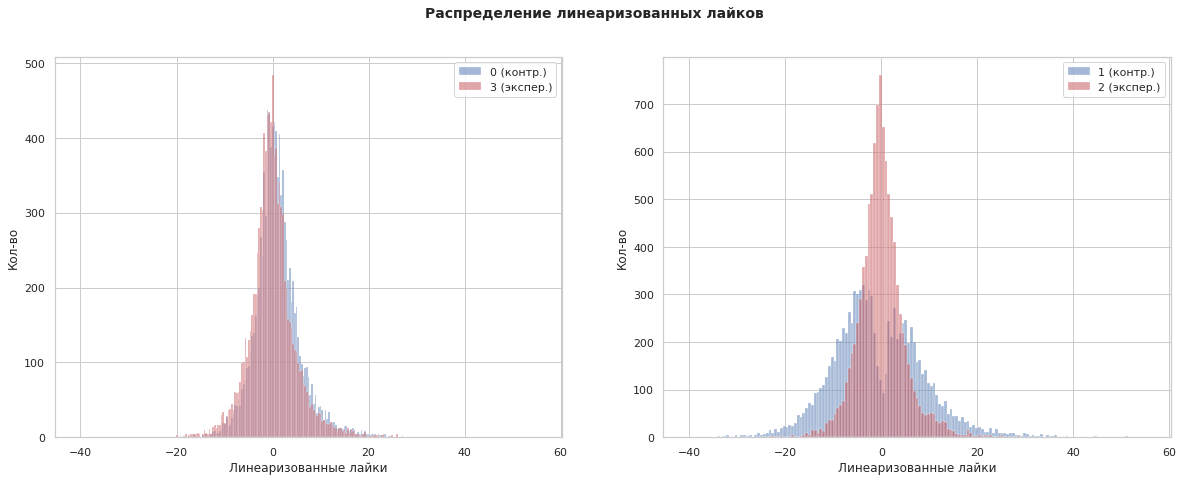

In [34]:
## Смотрим на распределение ключевой метрики (linearized_likes) в каждой группе ВО время эксперимента

# Создаем настройки для объединения графиков
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(20, 7), sharex=True)
fig.suptitle(f'Распределение линеаризованных лайков', fontweight='bold',fontsize=14)
# Задаем позиции
ax_1 = ax[0]
ax_2 = ax[1]

# Группы 0 и 3
sns.set_style("whitegrid")
groups = sns.histplot(data=df_03,
                     x='linearized_likes',
                     hue='exp_group',
                     palette=['r', 'b'],
                     alpha=0.5,
                     kde=False,
                     legend=True,
                     ax=ax_1)
# Добавляем подписи 
ax_1.legend(['0 (контр.)','3 (экспер.)'])
ax_1.set_xlabel('Линеаризованные лайки')
ax_1.set_ylabel('Кол-во')

# Группы 1 и 2
sns.set_style("whitegrid")
sns.histplot(data=df_12,
                     x='linearized_likes',
                     hue='exp_group',
                     palette=['r', 'b'],
                     alpha=0.5,
                     kde=False,
                     legend=True,
                     ax=ax_2)

# Добавляем подписи
ax_2.legend(['1 (контр.)','2 (экспер.)'])
ax_2.set_xlabel('Линеаризованные лайки')
ax_2.set_ylabel('Кол-во')

In [93]:
# Проводим ttest (распределение нормальное)

ttest_03 = stats.ttest_ind(df_03[df_03.exp_group == 0].linearized_likes, df_03[df_03.exp_group == 3].linearized_likes)
ttest_12 = stats.ttest_ind(df_12[df_12.exp_group == 1].linearized_likes, df_12[df_12.exp_group == 2].linearized_likes)


print('Результаты AB теста')
print(f'  p-value для групп 0 и 3: {ttest_03[1]}', f'  p-value для групп 1 и 2: {ttest_12[1]}', sep="\n")

Результаты AB теста
  p-value для групп 0 и 3: 5.454089613384093e-52
  p-value для групп 1 и 2: 8.136173836093922e-10


**Выводы**: 
 1. На графике "Распределение linearized_likes (группа 0 и 3)" мы видим смещещение результатов эксперементальной группы немного левее - предположительно **эффект есть, но отрицательный**;
 2. Ttest подтверждает результаты - p-value < 0.05;
 3. На графике "Распределение linearized_likes (группа 1 и 2)" мы видим различие между группами - предположительно **эффект есть**, но с направленность уже сложнее;
 4. Ttest подтверждает результаты - p-value < 0.05;

## Верифицируем выводы

In [91]:
# Проверим результаты на тесте Манна-Уитни

mw_03 = stats.mannwhitneyu(df_03[df_03.exp_group == 0].linearized_likes, df_03[df_03.exp_group == 3].linearized_likes)
mw_12 = stats.mannwhitneyu(df_12[df_12.exp_group == 1].linearized_likes, df_12[df_12.exp_group == 2].linearized_likes)


print('Результаты AB теста')
print(f'  p-value для групп 0 и 3: {mw_03[1]}', f'  p-value для групп 1 и 2: {mw_12[1]}', sep="\n")

Результаты AB теста
  p-value для групп 0 и 3: 1.1517315029786597e-63
  p-value для групп 1 и 2: 9.404319579641738e-27


#### Сравниваем результаты с CTR

In [110]:
# Проводим ttest (распределение нормальное)

ttest_03_CTR = stats.ttest_ind(df_03[df_03.exp_group == 0].CTR, df_03[df_03.exp_group == 3].CTR)
ttest_12_CTR = stats.ttest_ind(df_12[df_12.exp_group == 1].CTR, df_12[df_12.exp_group == 2].CTR)


print('Сравнение результов AB теста')
print(f'  p-value для групп 0 и 3: CTR > linearized_likes    {ttest_03_CTR[1] > ttest_03[1]}', 
      f'  p-value для групп 1 и 2: CTR > linearized_likes    {ttest_12_CTR[1] > ttest_12[1]}', 
      sep="\n")


print('Разница p-value при СTR и линеаризованных лайках')
print(f'  для групп 0 и 3: {round(ttest_03_CTR[1] - ttest_03[1], 15)}')
print(f'  для групп 1 и 2: {round(ttest_12_CTR[1] - ttest_12[1], 2)}')

Сравнение результов AB теста
  p-value для групп 0 и 3: CTR > linearized_likes    True
  p-value для групп 1 и 2: CTR > linearized_likes    True
Разница p-value при СTR и линеаризованных лайках
  для групп 0 и 3: 0.0
  для групп 1 и 2: 0.48


**Следовательно**, наша новая метрика дает меньший показатель p-value в ttest. А для групп 1 и 2 так с большой разницей.

## Выводы

Мы использовали новую центральную метрику, чтобы измерить эффект от нового алгоритма рекомендаций постов. По сравнению с обычной метрикой CTR "линеаризованные лайки" дают нам на выходе меньший p-value при проведении ttest. 

Однако немного сложно интерпретировать такую метрику. И я бы посмотрела на "теоретическое" подкрепление данной метрики, чтобы не было похоже на манипуляцию с метриками, дабы получить желаемую разницу в реузльтатах.
